<a href="https://colab.research.google.com/github/jsleroux/ReinforcementLearningProjects/blob/master/Q_learning_CartPole_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QLearning - CartPole

### Inspiration
- Original version of the code was taken from the exercices of CS188@Berkeley
- Collections.deque trick to compute running average: https://ferdinand-muetsch.de/cartpole-with-qlearning-first-experiences-with-openai-gym.html

### Frozen Lake testing

In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Dependencies

In [0]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install torch==1.0.0 > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (41.0.1)


# Imports and Helper functions


In [0]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor

gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import torch
from collections import deque
%matplotlib inline

import math
import glob
import io
import base64

from IPython.display import HTML
from IPython import display as ipythondisplay

In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1001'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
# Start virtual display
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1024, 768))
display.start()
import os
os.environ["DISPLAY"] = ":" + str(display.display) + "." + str(display.screen)


In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    

def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env

In [0]:
# Code to reset environment
def reset_env():
    while True:
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            break

In [0]:
def get_bins():

    bins = {}
    
    # poleangle
    minimum = env.observation_space.low[2]
    maximum = env.observation_space.high[2]
    bins['poleangle'] = pd.cut([minimum, maximum], bins=6, retbins=True)[1]
    
    # polevelocity
    bins['polevelocity'] = pd.cut([-1, 1], bins=12, retbins=True)[1]

    return bins


def state_encoder(observation, bins):
    cartposition = observation[0]     # x
    cartvelocity = observation[1]     # x_dot
    poleangle = observation[2]        # theta
    polevelocity = observation[3]     # theta_dot
	
    # cartposition
    x1 = 0
    
    # cartvelocity
    x2 = 0
    
    # poleangle
    x3 = pd.cut([poleangle], bins=bins['poleangle'], labels=False)[0]
    if (pd.isnull(x3)):
        x3 = -1
    
    # cartvelocity
    x4 = pd.cut([polevelocity], bins=bins['polevelocity'], labels=False)[0]
    if (pd.isnull(x4)):
        x4 = -1
    
    return (x1, x2, x3, x4)


In [0]:
def get_epsilon(t):
    min_epsilon = 0.1
    ada_divisor = 25
    return max(min_epsilon, min(1, 1.0 - math.log10((t + 1) / ada_divisor)))

def get_alpha(t):
    min_alpha = 0.1
    ada_divisor = 25
    return max(min_alpha, min(1.0, 1.0 - math.log10((t + 1) / ada_divisor)))

In [0]:
def getQValue(state, action):
    return qvalues[state + (action, )]


def computeActionFromQValues(state):
    legalActions = [i for i in range(env.action_space.n)]
    list_actions = []

    # get list of actions with max qvalues
    max_value = computeValueFromQValues(state)
    for action in legalActions:
        if getQValue(state, action) == max_value:
            list_actions.append(action)

    return random.choice(list_actions)


def computeValueFromQValues(state):
    return qvalues[state].max()
    

def update(old_observation, action, observation, reward):
    
    # old estimate
    old_estimate = getQValue(old_observation, action)

    # new sample estimate
    new_estimate = reward + (discount*computeValueFromQValues(observation))
    
    # running average
    new_qvalue = ((1 - alpha)*old_estimate) + (alpha*new_estimate)

    qvalues[old_observation + (action, )] = new_qvalue

# Perform learning

In [0]:
#from gym.envs.registration import register
#register(
#    id='FrozenLakeNotSlippery-v0',
#    entry_point='gym.envs.toy_text:FrozenLakeEnv',
#    kwargs={'map_name' : '4x4', 'is_slippery': False},
#    max_episode_steps=100,
#    reward_threshold=0.78, # optimum = .8196
#)

In [0]:
#env = wrap_env(gym.make("FrozenLake-v0"))
#env = wrap_env(gym.make("FrozenLakeNotSlippery-v0"))
env = gym.make("CartPole-v0")

In [0]:
# Print inforrmation about the gym
print(env.action_space)
print(env.observation_space)

Discrete(2)
Box(4,)


In [0]:
ep_steps = pd.DataFrame()
qvalues = torch.zeros(1, 1, 6, 12, env.action_space.n)
nepisodes = 300
discount = 1

In [0]:
nepisode = 0
scores = deque(maxlen=100)
solved = 0
bins = get_bins()

for _ in range(nepisodes):
    old_observation = observation = state_encoder(env.reset(), bins)
    
    nsteps = 0
    
    while True:        
        epsilon = get_epsilon(nepisode)
        alpha = get_alpha(nepisode)
        
        nsteps += 1
        
        # Choose action
        if random.random() < epsilon:
            action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            observation = state_encoder(observation, bins)
            
        else:
            action = computeActionFromQValues(observation)
            observation, reward, done, info = env.step(action)
            observation = state_encoder(observation, bins)
            
        # update
        update(old_observation, action, observation, reward)
        
        # assign old observation
        old_observation = observation
                    
        if done: 
            nepisode += 1
            ep_steps.loc[nepisode, 'step'] = nsteps
            if nepisode % 10 == 0:
                print('episode {} is done: {}'.format(nepisode, nsteps))

            scores.append(nsteps)

            mean_score = np.mean(scores)
            if mean_score >= 195 and nepisode >= 100:
                solved = 1
                print('Solved after {} episodes'.format(nepisode))
            break

    if solved:
        break

episode 10 is done: 23
episode 20 is done: 35
episode 30 is done: 12
episode 40 is done: 16
episode 50 is done: 14
episode 60 is done: 22
episode 70 is done: 143
episode 80 is done: 39
episode 90 is done: 15
episode 100 is done: 36
episode 110 is done: 56
episode 120 is done: 146
episode 130 is done: 200
episode 140 is done: 38
episode 150 is done: 139
episode 160 is done: 200
episode 170 is done: 200
episode 180 is done: 200
episode 190 is done: 200
episode 200 is done: 200
episode 210 is done: 200
episode 220 is done: 200
episode 230 is done: 200
episode 240 is done: 200
episode 250 is done: 200
Solved after 255 episodes


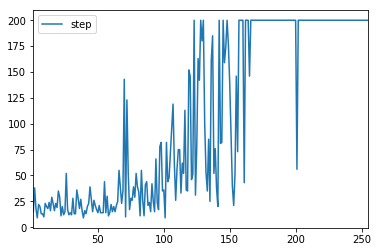

In [0]:
ep_steps.plot(kind='line')

### Watch the learned policy

In [0]:
#reset_env()

In [0]:
env = wrap_env(gym.make("CartPole-v0"))

old_observation = observation = state_encoder(env.reset(), bins)
step = 0

while True:
    env.render()
        
    epsilon = 0
        
    action = computeActionFromQValues(observation)
    observation, reward, done, info = env.step(action)
    observation = state_encoder(observation, bins)
                  
    step+=1
        
    if done: 
        print('Done!', step)
        break;

env.close()    

show_video()


Done! 200


### Appendices

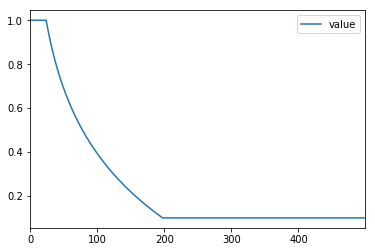

In [0]:
epsilon_adaptive_learning = pd.DataFrame()
for i in range(500):
    epsilon_adaptive_learning.loc[i, 'value'] = get_epsilon(i)
    
epsilon_adaptive_learning.plot(kind='line')

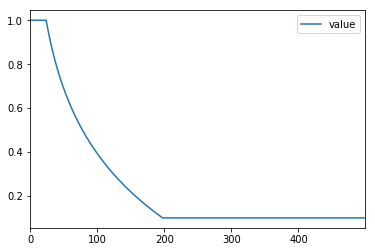

In [0]:
alpha_adaptive_learning = pd.DataFrame()
for i in range(500):
    alpha_adaptive_learning.loc[i, 'value'] = get_alpha(i)
    
alpha_adaptive_learning.plot(kind='line')